In [29]:
# test loadCESMLE

import cccmautils as cutl
import loadCESMLE as cle

%matplotlib inline

cle = reload(cle)

regions = {'EUR': 'eurasiamori',
           'BKS': 'bksmori',
           'GM': 'gm',
           'NH': 'nh',
           'EPAC': 'etroppac'}

local=True

savez500 = True # save 2D to npy files
savesat = True

npydir = '/HOME/rkm/pyscripts/pynpyfiles/'

casename = 'B20TRC5CNBDRD-BRCP85C5CNBDRD'
timesel = '1979-01-01,2012-12-31'
timeselc = '1979-01-01,1989-12-31'
timeselp = '2002-01-01,2012-12-31'

sea='DJF'


cle = reload(cle)
lat=cle.get_lat(local=local)
lon=cle.get_lon(local=local)
nlat=len(lat); nlon=len(lon)


lat: squeezing data upon read all
lon: squeezing data upon read all


In [18]:
# ========== 1D data =============
fdicteursat = {'field': 'TREFHT'+ regions['EUR'], 'ncfield': 'TREFHT', 'comp': 'cam'}
conv=1
cledateursat = cle.load_LEdata(fdicteursat,casename,timesel=timesel, 
                       rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True)

fdicteurz = {'field': 'Z3500'+ regions['EUR'], 'ncfield': 'Z3', 'comp': 'cam'}
conv=1
cledateurz = cle.load_LEdata(fdicteurz,casename,timesel=timesel, 
                       rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True)
fdictbksz = {'field': 'Z3500'+ regions['BKS'], 'ncfield': 'Z3', 'comp': 'cam'}
conv=1
cledatbksz = cle.load_LEdata(fdictbksz,casename,timesel=timesel, 
                       rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True) # @@@@


print cledateursat.shape
print cledatbksz.shape


#clebkssicr = cutl.seasonalize(ledatbkssic.T,season=sea)
cleeursatr = cutl.seasonalize(cledateursat.T,season=sea)
cleeurzr = cutl.seasonalize(cledateurz.T,season=sea)
clebkszr = cutl.seasonalize(cledatbksz.T,season=sea)

print cleeursatr.shape

/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.001.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.002.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.003.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.004.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.005.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.006.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.007.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBD

In [4]:
def load_process_field(fdict, conv=1, 
                       timeselc='1979-01-01,1989-12-31',
                       timeselp='2002-01-01,2012-12-31', 
                       sea='DJF',
                       verb=False):
    """ returns processed data for timeselc, timeselp in tuple
    """

    clefldspc={}; clefldspp={}
    for cleii in range(1,31):

        subens = (cleii,cleii+1)
        print subens


        # get 2D data 

        clec = cle.load_LEdata(fdict,casename,timesel=timeselc, 
                               rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=verb,
                                subens=subens) 
        print clec.shape    

        # move time into first dimension
        clec = np.transpose(clec,(1,0,2))
        clec = np.squeeze(cutl.seasonalize(clec,season=sea))
        clefldspc[cleii] = clec.mean(axis=0)
        print clefldspc[cleii].shape


        clep = cle.load_LEdata(fdict,casename,timesel=timeselp, 
                               rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=verb,
                                subens=subens) 
        print clep.shape    

        # move time into first dimension
        clep = np.transpose(clep,(1,0,2))
        clep = np.squeeze(cutl.seasonalize(clep,season=sea))
        clefldspp[cleii] = clep.mean(axis=0)
        print clefldspp[cleii].shape


    cleretc = np.array(clefldspc.values())
    cleretp = np.array(clefldspp.values())    
    # Now we have CTL and PERT time average spatial maps for e/ ens member
    
    return cleretc, cleretp

In [26]:
# calculate regressions w/ space
def slopemap(inr,insp,dims):
    """   
          inr is 1D [time or numens]
          insp is 2D [time or numens x space.flat]
          dims are a tuple of dims to reshape space to (nlat,nlon) 

          returns slopemap [dims]           
    """ 
    #print inr.shape, insp.shape
    
    slope,intercept = np.polyfit(inr,insp, 1)
    slopemap = slope.reshape(dims)

    return slopemap

In [13]:
# ============= 2D DATA =================
if savez500:
    
    # get 2D data (Z500)
    conv=1
    fdictz = {'field': 'Z3500', 'ncfield': 'Z3', 'comp': 'cam'} # spatial
    
    clez500spc, clez500spp = load_process_field(fdictz)
    
    """clez500spc={}; clez500spp={}
    for cleii in range(1,31):

        subens = (cleii,cleii+1)
        print subens

        clec = cle.load_LEdata(fdictz,casename,timesel=timeselc, 
                               rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True,
                                subens=subens) 
        print clec.shape    

        # move time into first dimension
        clec = np.transpose(clec,(1,0,2))
        clec = np.squeeze(cutl.seasonalize(clec,season=sea))
        clez500spc[cleii] = clec.mean(axis=0)
        print clez500spc[cleii].shape


        clep = cle.load_LEdata(fdictz,casename,timesel=timeselp, 
                               rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True,
                                subens=subens) 
        print clep.shape    

        # move time into first dimension
        clep = np.transpose(clep,(1,0,2))
        clep = np.squeeze(cutl.seasonalize(clep,season=sea))
        clez500spp[cleii] = clep.mean(axis=0)
        print clez500spp[cleii].shape


    clez500spc = np.array(clez500spc.values())
    clez500spp = np.array(clez500spp.values())"""
    print clez500spc.shape
    print clez500spp.shape
    
    # Now we have CTL and PERT time average spatial maps for e/ ens member

        
    matname = npydir + 'regressdat/cesm/z500spctl_' + \
        sea + '_LEtimeavg' + timeselc +'.npy' 
    np.save(matname,np.array(clez500spc))
    
    matname = npydir + 'regressdat/cesm/z500sppert_' + \
        sea + '_LEtimeavg' + timeselp +'.npy' 
    np.save(matname,np.array(clez500spp))

else:
    matname = npydir + 'regressdat/cesm/z500spctl_' + \
        sea + '_LEtimeavg' + timeselc +'.npy' 
    clez500spc = np.load(matname)
    
    matname = npydir + 'regressdat/cesm/z500sppert_' + \
        sea + '_LEtimeavg' + timeselp +'.npy' 
    clez500spp = np.load(matname)

(1, 2)
/HOME/rkm/work/DATA/cesm1//Z3500/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.001.cam.h0.Z3500.192001-202012.nc
 @@ fname1 /HOME/rkm/work/DATA/cesm1//Z3500/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.001.cam.h0.Z3500.192001-202012.nc
(1, 132, 55296)
(1, 132, 55296)
(1, 132, 55296)
(55296,)
/HOME/rkm/work/DATA/cesm1//Z3500/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.001.cam.h0.Z3500.192001-202012.nc
 @@ fname1 /HOME/rkm/work/DATA/cesm1//Z3500/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.001.cam.h0.Z3500.192001-202012.nc
(1, 132, 55296)
(1, 132, 55296)
(1, 132, 55296)
(55296,)
(2, 3)
/HOME/rkm/work/DATA/cesm1//Z3500/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.002.cam.h0.Z3500.192001-202012.nc
 @@ fname1 /HOME/rkm/work/DATA/cesm1//Z3500/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.002.cam.h0.Z3500.192001-202012.nc
(1, 132, 55296)
(1, 132, 55296)
(1, 132, 55296)
(55296,)
/HOME/rkm/work/DATA/cesm1//Z3500/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.002.cam.h0.Z3500.192001-202012.nc
 @@ fname1 /

In [12]:
if savesat:
    fdictsat = {'field': 'TREFHT', 'ncfield': 'TREFHT', 'comp': 'cam'}
    conv=1

    clesatspc, clesatspp = load_process_field(fdictsat)
    
    matname = npydir + 'regressdat/cesm/satspctl_' + \
        sea + '_LEtimeavg' + timeselc +'.npy' 
    np.save(matname,np.array(clesatspc))
    
    matname = npydir + 'regressdat/cesm/satsppert_' + \
        sea + '_LEtimeavg' + timeselp +'.npy' 
    np.save(matname,np.array(clesatspp))

else:
    matname = npydir + 'regressdat/cesm/satspctl_' + \
        sea + '_LEtimeavg' + timeselc +'.npy' 
    clesatspc = np.load(matname)
    
    matname = npydir + 'regressdat/cesm/satsppert_' + \
        sea + '_LEtimeavg' + timeselp +'.npy' 
    clesatspp = np.load(matname)
    
    

In [14]:
# calc anomalies for regression across ensemble

clesatspan = clesatspp - clesatspc
clez500span = clez500spp - clez500spc


In [35]:

print cleeursatr.shape
# what about interannual correlations in e/ simulation:
#  first create circ index
clecirc = clebkszr/clebkszr.std(axis=0)-cleeurzr/cleeurzr.std(axis=0)
print clecirc.shape

# to match CanESM (scatter plot):
clecirczstd = (clebkszr-clebkszr.mean(axis=0))/clebkszr.std(axis=0) -\
                  (cleeurzr-cleeurzr.mean(axis=0))/cleeurzr.std(axis=0)
clecirczstdan = clecirczstd[-10:,...].mean(axis=0) - clecirczstd[:10,...].mean(axis=0)

clemmt,clebbt,clervt,clepvt = cutl.regress(clecirc,cleeursatr)
print clervt.shape
clemmtdtr,clebbtdtr,clervtdtr,clepvtdtr = cutl.regress(cutl.detrend(clecirc,axis=0),cutl.detrend(cleeursatr,axis=0))
print clervtdtr.shape


cleeursatranom = cleeursatr[-10:].mean(axis=0) - cleeursatr[:10].mean(axis=0)
cleeurzranom = cleeurzr[-10:].mean(axis=0) - cleeurzr[:10].mean(axis=0)
clebkszranom = clebkszr[-10:].mean(axis=0) - clebkszr[:10].mean(axis=0)

# for CanESM I don't think I calc'd the ensemble circ index w/ std of each term.
clecircanom = clebkszranom/clebkszranom.std() - cleeurzranom/cleeurzranom.std()
clecirczan = clebkszranom - cleeurzranom
clecirczanstd = clecirczan / clecirczan.std()
# for scatter, to match CanESM:


print clecirczan.shape
print clecirczanstd.shape


(33, 30)
(33, 30)
(30,)
(30,)
(30,)
(30,)


(30,)
regress mm,bb,pval,rval: -0.289700083125 0.625144132035 7.34318504456e-06 -0.719801323118
-0.289700083125 0.625144132035 -0.719801323118 7.34318504456e-06
regress mm,bb,pval,rval: -0.509526052552 0.737754133035 0.000516777961963 -0.595528991187
-0.509526052552 0.737754133035 -0.595528991187 0.000516777961963
(33, 30)
min/max slopes -1.23034464959, -0.587015128983
min/max correlations -0.911963328555, -0.639183937873


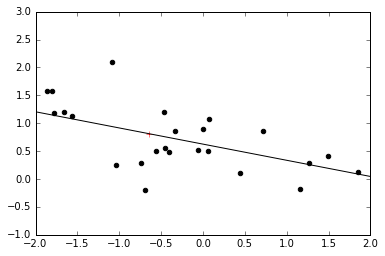

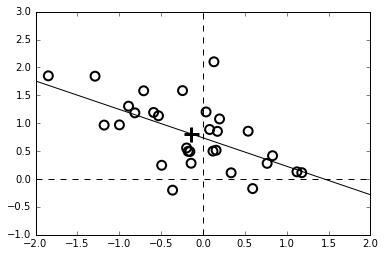

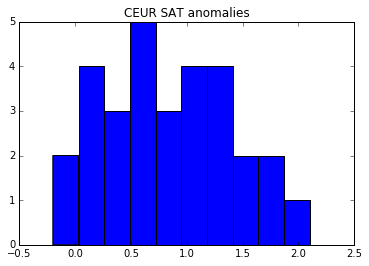

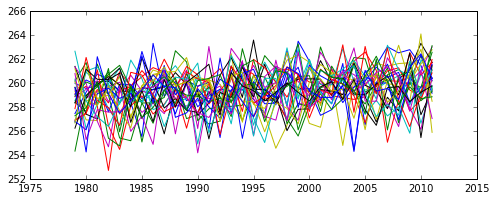

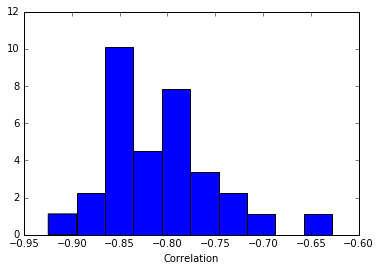

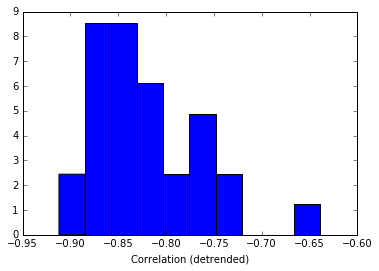

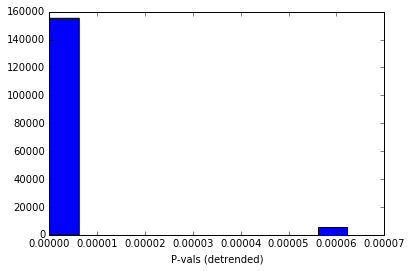

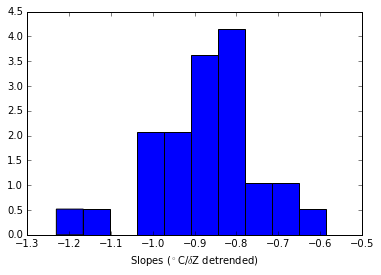

In [43]:
print clecircanom.shape

# this is what is plotted in paper scatter plot for CanESM
# lecirczrstd = (lebkszr-lebkszr.mean(axis=0))/lebkszr.std(axis=0) -\
#                  (leeurzr-leeurzr.mean(axis=0))/leeurzr.std(axis=0)
# lecirczrstdan = lecirczrstd[-10:,...].mean(axis=0) - lecirczrstd[:10,...].mean(axis=0)
# What does it mean to regress spatially on a different metric? @@@@@@

plt.figure()
plt.scatter(clecircanom,cleeursatranom,color='k')
plt.plot(clecircanom.mean(),cleeursatranom.mean(),marker='+',color='r')
cplt.add_regressline(clecircanom,cleeursatranom,color='k')
plt.xlim((-2,2))
plt.ylim((-1,3))

mm,bb,rval,pval = cutl.regress(clecircanom,cleeursatranom)
print mm,bb,rval,pval 

# this one like CanESM paper fig
plt.figure()
plt.scatter(clecirczstdan,cleeursatranom,linewidths=2,edgecolor='k',s=80, facecolors='none', marker='o')
plt.plot(clecirczstdan.mean(),cleeursatranom.mean(),marker='+',markersize=15,color='k',mew=3,mec='k')
plt.xlim((-2,2))
plt.ylim((-1,3))
cplt.add_regressline(clecirczstdan,cleeursatranom,color='k')
plt.axvline(x=0,linestyle='--',color='k')
plt.axhline(y=0,linestyle='--',color='k')

mm,bb,rval,pval = cutl.regress(clecirczstdan,cleeursatranom)
print mm,bb,rval,pval 


plt.figure()
plt.hist(cleeursatranom)
plt.title('CEUR SAT anomalies')

xx = np.arange(1979,2012)
print cleeursatr.shape
plt.figure(figsize=(8,3))
ret = plt.plot(xx,cleeursatr)


plt.figure()
plt.hist(clervt,normed=True)
plt.xlabel('Correlation')

plt.figure()
plt.hist(clervtdtr,normed=True)
plt.xlabel('Correlation (detrended)')

plt.figure()
plt.hist(clepvtdtr,normed=True)
plt.xlabel('P-vals (detrended)')

plt.figure()
plt.hist(clemmtdtr,normed=True)
plt.xlabel('Slopes ($^\circ$C/$\delta$Z detrended)')

print 'min/max slopes ' + str(np.min(clemmtdtr)) + ', ' + str(np.max(clemmtdtr))
print 'min/max correlations ' + str(np.min(clervtdtr)) + ', ' + str(np.max(clervtdtr))


In [31]:

z500oncircz = slopemap(clecirczanstd,clez500span,(nlat,nlon)) # Z500 regress on circidx
satoncircz = slopemap(clecirczanstd,clesatspan,(nlat,nlon))


Z500 contours
[-15. -12.  -9.  -6.  -3.   3.   6.   9.  12.  15.]


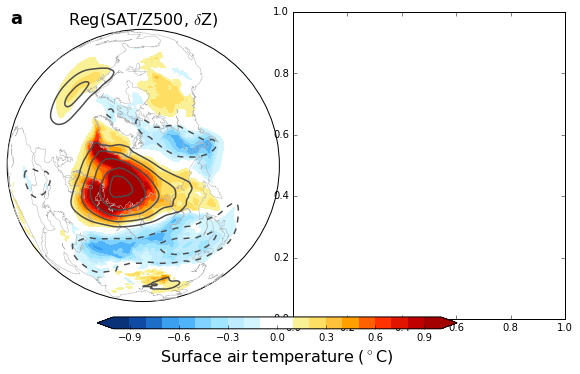

In [44]:
printtofile=False

cminsp=-1; cmaxsp=1
cminsp2=-3; cmaxsp2=3
#cminsp2=-2.5; cmaxsp2=2.5

cmlen=15.
incr = (cmaxsp2-cminsp2) / (cmlen)
conts = np.arange(cminsp2,cmaxsp2+incr,incr)


plotparams = {'lcol':'0.7', 'cmin': cminsp, 'cmax': cmaxsp, 'suppcb': True,
              'ptype': 'nheur', 'coastres': 'c', 'coastwidth': 0.5, 
              'area_thresh':70000}
contcol='0.3'
fsz=18
lws=1.5



ttl1='Reg(SAT/Z500, $\delta$Z)' 
ttl2='Reg(SAT/Z500, BKS ice)' 

cmlenz=10.
incrz = (15-(-15)) / (cmlenz)
tmpz = np.arange(-15,15+incrz,incrz)
# remove zero contour
contsz = np.zeros(len(tmpz)-1)
contsz[0:5] = tmpz[0:5]
contsz[5:] = tmpz[6:]


print 'Z500 contours'
print contsz



fig,axs=plt.subplots(1,2)
fig.set_size_inches(10,5.5)
fig.subplots_adjust(wspace=0.05)
ax=axs[0]
bm,pc=cplt.kemmap(satoncircz,lat,lon,axis=ax,
                  title=ttl1, panellab='a',**plotparams) 
#cplt.add_contours(bm, slponcircp,lat,lon,levels=conts,colors=contcol,linewidths=lws)
cplt.add_contours(bm, z500oncircz,lat,lon,levels=contsz,colors=contcol,linewidths=lws)

ax.set_title(ttl1,fontsize=fsz-2)

#ax=axs[1]
#bm,pc=cplt.kemmap(-satonsic,lat,lon,axis=ax,
#                  title=ttl2, panellab='b',**plotparams) 
#cplt.add_contours(bm,-slponsic,lat,lon,levels=conts,colors=contcol,linewidths=lws)
#cplt.add_contours(bm,-z500onsic,lat,lon,levels=contsz,colors='g',linewidths=lws)
#ax.set_title(ttl2,fontsize=fsz-2)

cplt.add_colorbar(fig,pc,orientation='horizontal', pos=[.25,.1, .5,.03],
                  label='Surface air temperature ($^\circ$C)',fontsize=16)

if printtofile:
    fig.savefig('CESMLE_regressiononcircidx_bkssic.pdf')
    fig.savefig('CESMLE_regressiononcircidx_bkssic.png',dpi=300)
